#### Implementación Lumped Parameter Model for adsorption, Xiao et al. (2013)

Contribuidores:
* Kieran Conradie
* Carlos Ullrich
* Felipe Huerta

In [1]:
# Integración numérica de sistemas de ecuaciones diferenciales ordinarias
from scipy.integrate import solve_ivp

# Minimización de funciones objetivos para ajuste de parámetros
from scipy.optimize import least_squares

# Ecuaciones no lineales
from scipy.optimize import fsolve

# Computación científica
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
# Copiar variables creando nuevos objetos
import copy

# Procesamiento de datos
# Importar pandas para cargar datos desde archivos .csv y otros
import pandas as pd
# CSV puro y duro
import csv

#### Definición sistema de ecuaciones diferenciales

In [2]:
# Función que es entregada a solve_ivp para resolver el modelo, se le entregara un BOOLEANO
# Para determinar si es carga o descarga

# Ec. no lineal para encontrar el valor de la presión para un valor
# de masa total conocida

def p_eqn(p, n_0, R, T, alpha, beta, b, p_0, M_H2, m_s, volumen, epsilon, m_t):
    ''' 
        Función objetivo que representa la masa total en función de la presión
        del sistema. Esto lo utilizamos ya que calculamos la presión de forma implícita
        en función de otras variables.
    '''
    # Calcular moles de hidrógeno adsorbido f(T,p)
    n_a = n_0 * np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
    # Actualizar masa adsorbida
    m_a = n_a*M_H2*m_s
    # Actualizar masa gas
    n_g = p*(volumen*epsilon)/(R*T)
    m_g = n_g * M_H2
    return m_t - (m_a + m_g)


def adsorcion_hidrogeno(t, y, c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon, volumen, area, p_0, n_0, b, m_dot, h, h_f, T_f, charge, DEBUG=False):
    # if charge:
        # print(f'Simulando proceso de carga\n--------------------------')
    
    # Desempacar variables:
    m_t = y[0]
    T = y[1]
    
    # Calcular Variables dependientes de las variables independientes
    p_old = 0.033*1e6 # Presión inicial (Pa) para test No. 13

    p = fsolve(p_eqn, p_old, args = (n_0, R, T, alpha, beta, b, p_0, M_H2, m_s, volumen, epsilon, m_t))

    # Calcular masa adsorbida
    n_a = n_0 * np.exp(-((R*T)/(alpha+beta*T))**b * np.log(p_0/p)**b)
    m_a = n_a*M_H2*m_s

    # Actualizar numero de moles en la fase gas
    m_g = m_t - m_a

    # Calor esostérico
    # dH = alpha * (np.log(p_0/p))**(1/b)
    dH = alpha * (np.log(n_0/n_a))**(1/b)
    
    # print(f'm_a: {m_a}\nm_g: {m_g}')

    # ECUACIONES DIFERENCIALES
    # Ecuación diferencial de masa total
    if charge:
        dm_dt = m_dot
    elif not charge:
        dm_dt = -m_dot
    else:
        dm_dt = 0
        
    # Ecuación diferencial de temperatura
    if charge:
        dT_dt = (m_dot*h + dm_dt*(dH/M_H2) - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)
    elif not charge:
        dT_dt = (-m_dot*h + dm_dt*(dH/M_H2) - h_f*area*(T-T_f))/(m_s*c_s + m_a*c_p + m_g*c_p + m_w*c_w)
    
    # DEBUG prints
    if DEBUG is True:
        print("\ndT_dt debugging \n")
        print("dT_dt = %.3e K/s" % dT_dt)
        print("m_dot = %.3e kg/s" % m_dot)
        print("h = %.3e Jm^2-" % h)
        print("dH = %.3e J/kg " % dH)
        print("M_H2 = %.3e kg/mol" % h)
        print("h_f = %.3e Wm^-2K^-1" % h_f)
        print("area = %.3e m^2" % area)
        print("T = %.3e K" % T)
        print("T_f = %.3e K" % T_f)        
        print("dm_dt = %.3e kg/s" % dm_dt)
        # Calor isoestérico
        print("\nIsosteric heat debugging\n")
        print("alpha = %.3e" % alpha)
        print("b= %.3e" % b)
        print("p_0 = %.3e Pa" % p_0)
        print("p = %.3e Pa" % p)

    # Empacar el vector del lado derecho en un vector 2x1
    
    print("dmdt", dm_dt)
    print("dTdt", dT_dt)

    dy = np.array([dm_dt, dT_dt[0]])
    
    return dy

#### Parametros, condiciones y solve_ivp

Parámetros asociados a la mezcla

In [3]:
# Propiedades termofísicas

# Calores especificos

c_p = 10167 # Calor especifico del hidrogeno (J kg-1 K-1)


# K: Originalmente estaba dado en J, por eso el /1000
# F: Sugerencia: ocupar unidades SI lo más posible

# Constantes 
R = 8.314 # J mol-1 K-1
alpha = 3080 # Factor entalpico (J mol-1)
beta = 18.9 # Factor entropico (J mol-1 K-1)
epsilon_b = 0.49 
b = 2

Equilibrio de adsorción

In [4]:
# Otros
p_0 = 1470 * 1e6 # Presion de saturacion (Pa)
n_0 = 71.6 # Cantidad limite de adsorcion (mol kg-1)

Parámetros asociados al tanque

In [5]:
# PARAMETROS

# Dimensiones estanque
V = 0.00015 # Volumen de estanque (m^3)    # No se si es volumen interno
l = 0.133 # m, alto del tanque
A_e = 2*np.pi*l # Área superficial estanque m^2  # considere manto cilindro superficial (no contamos "tapas")

# Masas
m_s = 0.671 # masa carbón activado (kg)    # datos del carbono, considerar que está lleno a un 30%.
m_w = 3.714 # Masa paredes de acero (kg)   # datos del carbono
M_H2 = 2.0159E-3 # Masa molar del hidrogeno (kg mol-1)

c_s = 825 # Calor especifico del carbón activado (J kg-1 K-1)     # datos del carbono
c_w = 500 # Calor especifico paredes de acero (J kg-1 K-1)    # este es a 20°C segun internet


# CONDICIONES INICIALES
p_ci = np.array([1.01235, 1.01235, 1.01235])*1e6 #Pa
T_ci = np.array([283, 283, 273]) #K 

# Temperatura del refrigerante
T_cf = np.array([282.5, 284.5, 282.2]) #K

# Coeficiente de transferencia de calor
# Calculado en Jupyter Notebook separado
h_cf = np.array([3.6, 3.6, 3.6]) # W m^-2 K^-1

# Flujos másicos referenciales
# Flujos de carga típicos 50 cm^3 / min
m_cdot = np.array([2.353e-09, 2.353e-09, 2.353e-09])*1e4       # kg s-1   # No hemos hecho experimento pero usado lo de profe fhuerta
# Se multiplicó por 10^4


# Lista de tiempos: Inicial, fin carga, inicio descarga
t_c0 =  np.array([0, 0, 0])           # s
t_cf = np.array([1042, 422, 175])          # s   # falta realizar exp
t_cd = np.array([3189, 2622, 2382])          # s   # falta realizar exp

# Entalpías de entrada y salida
h_in = np.array([3986.8, 4001.1, 3987.2])  # J/kg  # no alcance a buscar tablas
h_out = np.array([3718.8, 3752.6, 3719.3]) # J/kg  # no alcance a buscar tablas

In [6]:
# Presión de la alimentación
p_a = 35 * 1e5
R = 8.314 
T_alimentación = 298.15 # 25°C

# pv = nRT
# p = (n/v) * R * T
# rho = p/RT # mol/m^3
# rho = p/RT * 0.002 kg / mol

rho = p_a/(R*T_alimentación) * 0.002
print("rho %.3e kg/(m^3)" % rho)

rho 2.824e+00 kg/(m^3)


In [7]:
rho_cgs = rho * 1e3 /(1e6)

$\rho = 2.82 mg/cm$^3$

In [8]:
F = 50 / 60 #cm^3 / s

# flujo másico en mg/s
mdot_cgs = rho_cgs * F

mdot_final = mdot_cgs/1e6

print("mdot_final = %.3e kg/s" % mdot_final )

mdot_final = 2.353e-09 kg/s


#### Implementación del modelo

In [9]:
def resolver_modelo(index):
    # Seleccionar los valores del test deseado
    p_i = p_ci[index]
    T_i = T_ci[index]
    T_f = T_cf[index]
    h_f = h_cf[index]
    m_dot = m_cdot[index]
    t_0 = t_c0[index]
    t_f = t_cf[index]
    t_d = t_cd[index]
    h_i = h_in[index]
    h_o = h_out[index]
    

    n_a0 = n_0 * np.exp(- (R*T_i/(alpha + beta*T_i))**b * np.log(p_0/p_i)**b )

    n_gi = p_i*(V*epsilon_b)/(R*T_i)
    m_gi = n_gi * M_H2
    
    # Masa inicial total   (Lo agregué a la mala, no se si es coherente con el resto del código)
    m_ti = (n_a0+n_gi)*M_H2

    # PARAMETROS EN CARGA/DESCARGA
    # Carga o descarga?
    charge = True

    t_range = np.linspace(t_0, t_f, 100000)

    # Tupla de parametros que se deben pasar a solve_ivp
    DEBUG = False
    args = (c_s, c_p, c_w, m_s, m_w, M_H2, R, alpha, beta, epsilon_b, V, A_e, p_0, n_0, b, m_dot, h_i, h_f, T_f, charge, DEBUG)

    # En ingeniería química, sobre todo cuando hay reacciones o cambio de fases, se generan sistemas ultraestables
    # (ultrastiff) no conviene utilizar métodos explícitos. 
    sol = solve_ivp(adsorcion_hidrogeno, (t_0, t_f), [m_ti, T_i], args=args, t_eval= t_range, method = 'BDF')
    
    # Desempacar la sol.clear
    m_t = sol.y[0]
    T = sol.y[1]
    t = sol.t
    
    return t, m_t, T, p_i   # Agregué p_i para poder usarlo más tarde en el cálculo de la presión

In [10]:
t_result, m_t_result, T_result, p_i = resolver_modelo(1)

print(p_i)
print(T_result)

dmdt 2.353e-05
dTdt [0.04076379]
dmdt 2.353e-05
dTdt [0.04062156]
dmdt 2.353e-05
dTdt [0.04076379]
dmdt 2.353e-05
dTdt [0.04076379]
dmdt 2.353e-05
dTdt [0.04076379]
dmdt 2.353e-05
dTdt [0.04076014]
dmdt 2.353e-05
dTdt [0.04076014]
dmdt 2.353e-05
dTdt [0.04075648]
dmdt 2.353e-05
dTdt [0.04075648]
dmdt 2.353e-05
dTdt [0.04071996]
dmdt 2.353e-05
dTdt [0.04071998]
dmdt 2.353e-05
dTdt [0.04068352]
dmdt 2.353e-05
dTdt [0.04068354]
dmdt 2.353e-05
dTdt [0.04032153]
dmdt 2.353e-05
dTdt [0.04032329]
dmdt 2.353e-05
dTdt [0.03996714]
dmdt 2.353e-05
dTdt [0.03996911]
dmdt 2.353e-05
dTdt [0.03660274]
dmdt 2.353e-05
dTdt [0.03675874]
dmdt 2.353e-05
dTdt [0.03376834]
dmdt 2.353e-05
dTdt [0.03392678]
dmdt 2.353e-05
dTdt [0.02083638]
dmdt 2.353e-05
dTdt [0.01935141]
1012350.0000000001
[283.         283.00017201 283.00034402 ... 295.27132642 295.27140532
 295.27148421]


#### Gráfico Temperatura


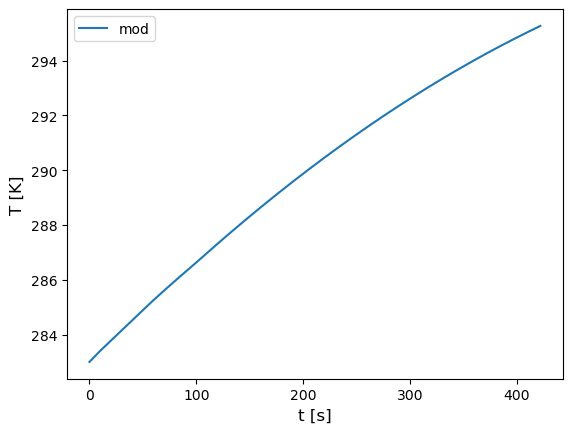

In [11]:
# Temperatura
plt.plot(t_result, T_result, label='mod')
### Validación experimental: ocupando datos previamente cargados y definidos para carga

# Graficamos los experimentos
#plt.plot(t_exp_T_c, T_exp_c, label='exp', marker ='o', ls='', color='k')

# Estética
plt.xlabel('t [s]', size = 12)
plt.ylabel('T [K]', size = 12)

# Visualización
plt.legend()
plt.show()

#### Cálculo Presión

In [12]:
# Como calculamos P, m_a y m_g?
p = []

for i in range(len(T_result)):
    # Se encuentra el valor de la presión mediante la función fsolve   (agregué m_t_result[i], porque m_t[i] no está definido)
    p_inst = fsolve(p_eqn, p_i, args = (n_0, R, T_result[i], alpha, beta, b, p_0, M_H2, m_s, V, epsilon_b, m_t_result[i]))
    # Se extrae el valor en el indice 0 porque p_inst es de la forma [float]
    # Se divide en 1e6 para pasar de Pa a MPa
    p_inst = p_inst[0]
    
    if i % 100000 == 0:
        print(f'En el indice [{i}] la presión es: {p_inst} Pa')

    p.append(p_inst)

p = np.array(p)
print(p[-1])

En el indice [0] la presión es: 1436344.834155797 Pa
8781720.90956313


#### Gráfico Presión

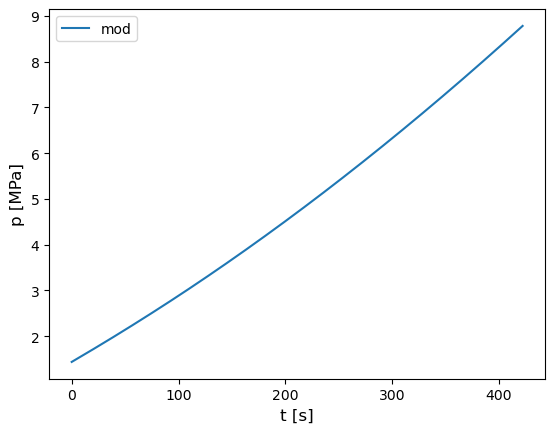

In [13]:
# Presión
plt.plot(t_result, p/1e6, label='mod')


### Validación experimental: ocupando datos previamente cargados y definidos para carga

# Graficamos los experimentos
#plt.plot(t_exp_p_c, p_exp_c, label='exp', marker ='o', ls='', color='k')

# Estética
plt.xlabel('t [s]', size = 12)
plt.ylabel('p [MPa]', size = 12)

# Visualización
plt.legend()
plt.show()


#### Masa fase adsorbida y fase gaseosa

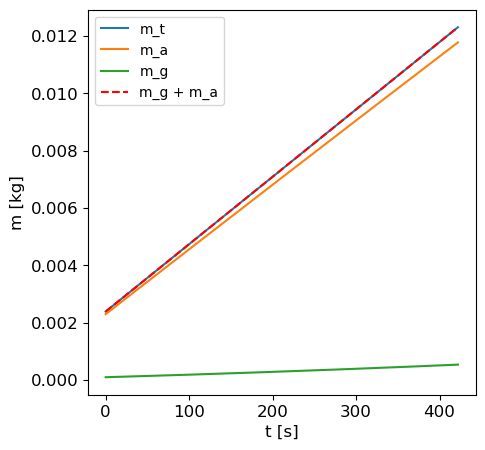

[1.69521426 1.69528502 1.69535579 ... 8.71089205 8.71096157 8.71103109]
[0.00229306 0.00229316 0.00229326 ... 0.01178295 0.01178305 0.01178314]


In [14]:
# Calcular los valores de masa y gas
n_a = n_0*np.exp(-((R*T_result)/(alpha+beta*T_result))**b * np.log(p_0/p)**b)
m_a = n_a*M_H2*m_s
m_a = np.array(m_a)
m_g = M_H2*p*(V*epsilon_b)/(R*T_result) 

# Graficar las líneas
plt.figure(figsize=[5, 5])
plt.plot(t_result, m_t_result, label='m_t')
plt.plot(t_result, m_a, label='m_a')
plt.plot(t_result, m_g, label='m_g')
plt.plot(t_result, m_g + m_a, "r--", label='m_g + m_a')

# Agregar leyendas al gráfico
plt.legend()

# Agrandar el tamaño de los números en el gráfico
plt.tick_params(labelsize=12)
plt.xlabel('t [s]', size=12)
plt.ylabel('m [kg]', size=12)

# Mostrar el gráfico
plt.show()

print(n_a)
print(m_a)